# Predicting models

In [1]:
#--- Import all necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#--- Drop unnecessary columns

df = pd.read_csv('price_w_coord.csv')
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 
                 'is_in_kokshetau', 'street', 'latitude', 'longitude', 'distance_to_center', 'repair_status', 'type_of_house'], axis=1, inplace=True)
df

,price,room,area,flat_toilets,balcony,current_floors,total_floors,ceiling,dorm,mortgage,year,distance_to_nearest_school,distance_to_nearest_kindergarten,distance_to_nearest_pharmacy
0,9500000,1.0,39.0,совмещенный,лоджия,4.0,5.0,2.7,нет,нет,1979.0,0.335102,0.336834,0.468495
1,39000000,2.0,76.1,раздельный,нет,4.0,10.0,3.0,нет,нет,2021.0,0.738231,2.777238,2.062675
2,29990000,2.0,75.0,раздельный,нет,9.0,10.0,3.0,нет,нет,2024.0,0.393297,0.360013,1.196087
3,10900000,2.0,37.0,совмещенный,балкон,1.0,5.0,2.7,нет,нет,1966.0,0.560507,0.449888,0.083088
4,13400000,2.0,50.8,совмещенный,нет,6.0,6.0,2.7,нет,нет,1990.0,0.785759,0.409501,0.488860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5088,20500000,3.0,57.1,раздельный,нет,4.0,5.0,2.7,нет,нет,1986.0,0.100153,0.319724,0.593581
5089,8500000,2.0,48.9,раздельный,нет,2.0,4.0,2.7,да,нет,1962.0,0.364670,0.937250,0.099384
5090,9500000,2.0,40.3,совмещенный,нет,1.0,4.0,2.7,нет,нет,1964.0,0.340605,1.020583,0.176307
5091,10000000,2.0,42.0,совмещенный,нет,3.0,5.0,2.7,да,нет,1982.0,0.686371,0.425723,0.151151


In [3]:
#--- Data processing from categorical to numerical

df['balcony'] = df['balcony'].apply(lambda x: 0 if x == 'нет' else 1)
df['flat_toilets'] = df['flat_toilets'].apply(lambda x: 0 if x == 'нет' else 1)

df['mortgage'] = df['mortgage'].map({'нет': 0, 'В залоге': 1})
df['dorm'] = df['dorm'].map({'нет': 0, 'да': 1})

print(df.isnull().sum())

price                               0
room                                0
area                                0
flat_toilets                        0
balcony                             0
current_floors                      0
total_floors                        0
ceiling                             0
dorm                                0
mortgage                            0
year                                0
distance_to_nearest_school          0
distance_to_nearest_kindergarten    0
distance_to_nearest_pharmacy        0
dtype: int64


The remaining columns are for correlation analysis:
Index(['price', 'room', 'area', 'flat_toilets', 'balcony', 'current_floors',
       'total_floors', 'ceiling', 'dorm', 'mortgage', 'year',
       'distance_to_nearest_school', 'distance_to_nearest_kindergarten',
       'distance_to_nearest_pharmacy'],
      dtype='object')


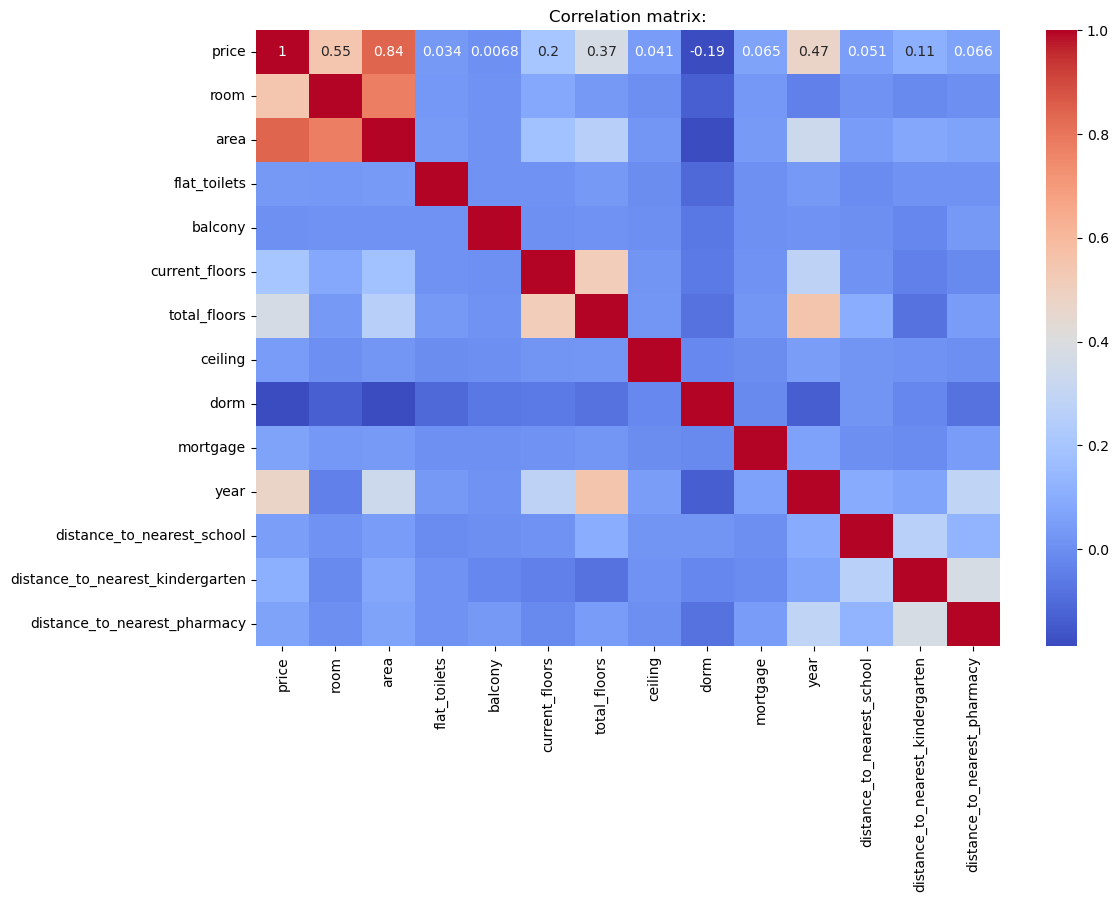

In [4]:
#--- Correlation matrix

numeric_df = df.select_dtypes(include=['float64', 'int64', 'int32'])

print("The remaining columns are for correlation analysis:")
print(numeric_df.columns)

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation matrix:")
plt.show()


In [5]:
#--- Creating new features to understand the data better

df["age_of_building"] = 2025 - df["year"]  
df["floor_ratio"] = df["current_floors"] / df["total_floors"]  
df["infrastructure_index"] = (
    df["distance_to_nearest_school"] + df["distance_to_nearest_kindergarten"] + df["distance_to_nearest_pharmacy"]
) / 3

df.drop(columns=["distance_to_nearest_school", "distance_to_nearest_kindergarten", "distance_to_nearest_pharmacy"], inplace=True)

df["price_per_sqm"] = df["price"] / df["area"]

print(df.head())

      price  room  area  flat_toilets  balcony  current_floors  total_floors  \
0   9500000   1.0  39.0             1        1             4.0           5.0   
1  39000000   2.0  76.1             1        0             4.0          10.0   
2  29990000   2.0  75.0             1        0             9.0          10.0   
3  10900000   2.0  37.0             1        1             1.0           5.0   
4  13400000   2.0  50.8             1        0             6.0           6.0   

   ceiling  dorm  mortgage    year  age_of_building  floor_ratio  \
0      2.7     0         0  1979.0             46.0          0.8   
1      3.0     0         0  2021.0              4.0          0.4   
2      3.0     0         0  2024.0              1.0          0.9   
3      2.7     0         0  1966.0             59.0          0.2   
4      2.7     0         0  1990.0             35.0          1.0   

   infrastructure_index  price_per_sqm  
0              0.380144  243589.743590  
1              1.859381  512

In [6]:
#--- Predict by different models and comparing

X = df.drop(columns=['price'])  
y = df['price']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    print(f"R² Score: {r2_score(y_test, y_pred):.3f}\n")

evaluate_model(LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test)
evaluate_model(Ridge(alpha=1.0), X_train_scaled, X_test_scaled, y_train, y_test)
evaluate_model(Lasso(alpha=0.1), X_train_scaled, X_test_scaled, y_train, y_test)

evaluate_model(RandomForestRegressor(n_estimators=100, random_state=42), X_train, X_test, y_train, y_test)
evaluate_model(XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42), X_train, X_test, y_train, y_test)


Model: LinearRegression
MAE: 1296738.47
RMSE: 2777153.83
R² Score: 0.938

Model: Ridge
MAE: 1295957.57
RMSE: 2777898.70
R² Score: 0.938

Model: Lasso
MAE: 1296738.32
RMSE: 2777153.87
R² Score: 0.938

Model: RandomForestRegressor
MAE: 295797.89
RMSE: 2710799.85
R² Score: 0.941

Model: XGBRegressor
MAE: 337755.61
RMSE: 2608418.29
R² Score: 0.946



In [7]:
#--- Real vs predict by RandomForest

model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

comparison = list(zip(y_test[:10], y_pred[:10]))

print("Real | Predict")
for actual, predicted in comparison:
    print(f"{actual:.2f} | {predicted:.2f}")


Real | Predict
18900000.00 | 18941632.00
13300000.00 | 13334666.64
33000000.00 | 33181000.00
9500000.00 | 9441000.00
180800000.00 | 98782407.17
16000000.00 | 16055000.00
19000000.00 | 18966570.00
11200000.00 | 11083000.00
33500000.00 | 33500000.00
12000000.00 | 12000000.00


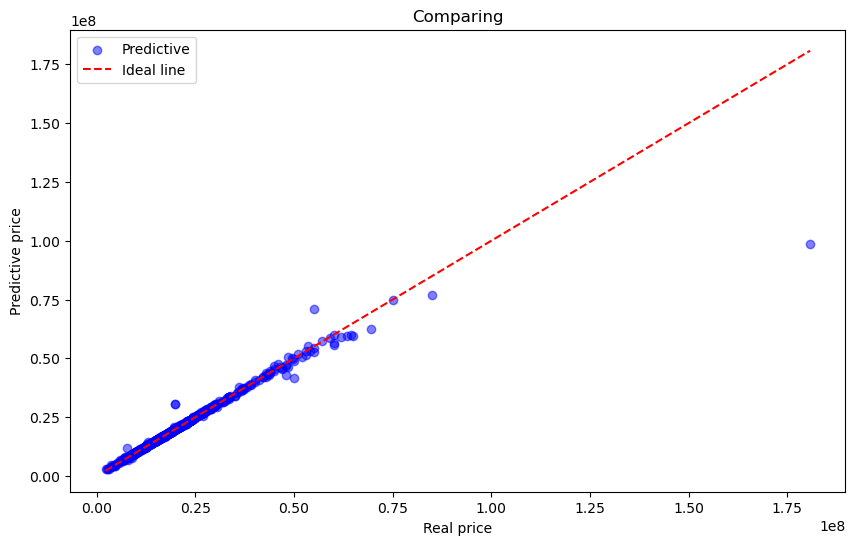

In [8]:
#--- Scatter plot to show the real and predictive price

y_test = y_test[:len(y_pred)]

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label="Predictive")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label="Ideal line")
plt.xlabel("Real price")
plt.ylabel("Predictive price")
plt.title("Comparing")
plt.legend()
plt.show()
